In [3]:
import urllib2
from bs4 import BeautifulSoup
import re
import nytimesarticle as nyta
import urllib2
import requests
import csv
import time
import pandas as pd
import numpy as np
import nytimes_crawl as nytc
import operator as op
import text_processing
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

# Misc

In [3]:
names = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen']

## Analysis

### Scrape

In [8]:
reader1 = nytc.OpEdReader('one')
reader1.save_oped_articles_all_pages(begindate='20160101',enddate='20160331')

In [ ]:
reader2 = nytc.OpEdReader('two')
reader2.save_oped_articles_all_pages(begindate='20161001',enddate='20160107')

In [ ]:
reader3 = nytc.OpEdReader('three')
reader3.save_oped_articles_all_pages(begindate='20150701',enddate='20151011')

In [ ]:
reader4 = nytc.OpEdReader('four')
reader4.save_oped_articles_all_pages(begindate='20150401',enddate='20150717')

In [ ]:
reader5 = nytc.OpEdReader('five')
reader5.save_oped_articles_all_pages(begindate='20150101',enddate='20150421')

In [ ]:
reader6 = nytc.OpEdReader('six')
reader6.save_oped_articles_all_pages(begindate='20141001',enddate='20150125')

### Load

In [4]:
reader1 = nytc.OpEdReader.init_from_file('one','one100.csv')
reader2 = nytc.OpEdReader.init_from_file('two','two100.csv')
reader3 = nytc.OpEdReader.init_from_file('three','three100.csv')
reader4 = nytc.OpEdReader.init_from_file('four','four100.csv')
reader5 = nytc.OpEdReader.init_from_file('five','five100.csv')
reader6 = nytc.OpEdReader.init_from_file('six','six100.csv')
reader7 = nytc.OpEdReader.init_from_file('seven','actual_seven100.csv')
reader8 = nytc.OpEdReader.init_from_file('eight','seven100.csv')
reader9 = nytc.OpEdReader.init_from_file('nine','eight100.csv')
reader10 = nytc.OpEdReader.init_from_file('ten','nine100.csv')

In [5]:
readers = [reader1,reader2,reader3,reader4,reader5,reader6,reader7,reader8,reader9,reader10]

### Eliminate 'Universal' Articles

In [6]:
def elim_universal_wrapper(reader):
    print(reader.data.shape)
    reader.elim_universal()
    print(reader.data.shape)

In [7]:
for reader in readers:
    elim_universal_wrapper(reader)

(947, 8)
(940, 8)
(952, 8)
(943, 8)
(959, 8)
(948, 8)
(945, 8)
(941, 8)
(944, 8)
(929, 8)
(955, 8)
(954, 8)
(953, 8)
(953, 8)
(967, 8)
(967, 8)
(965, 8)
(964, 8)
(948, 8)
(948, 8)


# Text Manipulation

## Foreign Language

In [8]:
def locate_foreign(tidiedtext,reader):
    for idx, text in enumerate(tidiedtext):
        if 'de' in text and 'la' in text:
            print('Match')
            print(idx)
            print(text[:20])
            print(reader.data['url'].iloc[idx])

In [9]:
def possible_matches(reader):
    text = reader.data['full_text']
    tidiedtext = []
    for item in text:
        try:
            newtext = text_processing.tidy_text(item.decode('utf-8'))
            tidiedtext.append(newtext)
        except:
            pass
    locate_foreign(tidiedtext,reader)

### Drop Foreign Articles and Nonsense Articles

In [10]:
def drop_rows_all(reader,indices):
    print(reader.data.shape)
    reader.drop_rows(indices)
    print(reader.data.shape)
    badidx = [i for i, item in enumerate(reader.data['full_text']) if not isinstance(item,str)]
    reader.drop_rows(badidx)
    csvfilename = '{0}_english{1}.csv'.format(reader.name,100)
    reader.save_to_csv(csvfilename)

In [11]:
drop_rows_all(reader,[105,355,508,534])
drop_rows_all(reader2,[55,396,459,504,516,542,549])
drop_rows_all(reader3,[])
drop_rows_all(reader4,[])
drop_rows_all(reader5,[])
drop_rows_all(reader6,[77,275,303,345,365,405,434,740,825,917])
drop_rows_all(reader7,[46,120,152,174,202])
drop_rows_all(reader8,[])
drop_rows_all(reader9,[])
drop_rows_all(reader10,[812])

(948, 8)
(944, 8)
(943, 8)
(936, 8)
(948, 8)
(948, 8)
(941, 8)
(941, 8)
(929, 8)
(929, 8)
(954, 8)
(944, 8)
(953, 8)
(948, 8)
(967, 8)
(967, 8)
(964, 8)
(964, 8)
(932, 8)
(931, 8)


## Save Results

In [12]:
for name, reader in zip(names,readers):
    filename = '{0}_english100.csv'.format(name)
    reader.save_to_csv(filename)

# Final Result

In [13]:
readers_english = []
for name in names[:10]:
    filename = '{0}_english100.csv'.format(name)
    readername = '{0}_english'.format(name)
    newreader = nytc.OpEdReader.init_from_file(readername,filename)
    readers_english.append(newreader)

# Join All

In [14]:
dataall = pd.concat([reader.data for reader in readers_english])
dataall = dataall.reset_index(drop=True);

# Fix Bad Names!

In [15]:
import time

In [16]:
def get_author_name(url):
    soup = nytc.soupify_url(url)
    time.sleep(2)
    tag = soup.findAll('meta',{'name':'author'})[0]
    return tag.get('content')

In [17]:
def get_last_name(authorname):
    return authorname.split()[-1]

In [18]:
def fix_bad_name(dataall,firstnamecheck):
    res = []
    for url, firstname, lastname in zip(dataall['url'],dataall['first_name'],dataall['last_name']):
        if firstname == firstnamecheck and pd.isnull(lastname):
            print(url)
            authorname = get_author_name(url)
            lastnamenew = get_last_name(authorname).lower()
        else:
            lastnamenew = lastname
        res.append(lastnamenew)
    dataall['last_name'] = res
    return dataall

In [19]:
dataall = fix_bad_name(dataall,'charles')
dataall = fix_bad_name(dataall,'thomas')

http://www.nytimes.com/2016/03/31/opinion/campaign-stops/bernie-or-bust-is-bonkers.html
http://www.nytimes.com/2016/03/28/opinion/republican-self-destruction.html
http://www.nytimes.com/2016/03/24/opinion/dangerous-world-serious-leaders.html
http://www.nytimes.com/2016/03/21/opinion/learning-lessons-from-outrage.html
http://www.nytimes.com/2016/03/17/opinion/campaign-stops/a-bernie-blackout.html
http://www.nytimes.com/2016/03/14/opinion/carson-endorses-the-demagogue.html
http://www.nytimes.com/2016/03/10/opinion/sanders-surprises.html
http://www.nytimes.com/2016/03/07/opinion/the-end-of-american-idealism.html
http://www.nytimes.com/2016/03/03/opinion/campaign-stops/demagogue-for-president.html
http://www.nytimes.com/2016/02/29/opinion/im-not-a-super-predator.html
http://www.nytimes.com/2016/02/25/opinion/campaign-stops/clinton-sanders-and-southern-voters.html
http://www.nytimes.com/2016/02/22/opinion/bernie-sanders-hits-a-roadblock.html
http://www.nytimes.com/2016/02/18/opinion/campaig

## Save Results

### Scraped

In [20]:
dataall.to_csv('dataall2.csv')

In [5]:
dataall = pd.DataFrame.from_csv('dataall2.csv')

### Dates

In [6]:
n_days = 7
daynames = ['Day{0}'.format(i) for i in range(n_days)]

#### Dates

In [7]:
dates = [pd.to_datetime(nytc.parse_url_for_date(url)) for url in dataall['url']]
datadate = pd.DataFrame(index=dataall.index,columns=['Dates','Times']+daynames)
datadate['Dates'] = dates

#### Normalized Time

In [8]:
dateoldest = dates[-1]
datenewest = dates[0]
daterange = datenewest - dateoldest
times = [(date - dateoldest)/daterange for date in dates]
datadate['Times'] = times

#### Day of Week

In [9]:
daysofweekarray = np.zeros((len(dataall),n_days))

In [10]:
daysofweek = [date.dayofweek for date in dates]
for i, day in enumerate(daysofweek):
    daysofweekarray[i,day] = 1
datadate[daynames] = daysofweekarray

#### Save

In [11]:
datadate.to_csv('datadate2.csv',encoding='utf-8')

### Tidied Text

In [28]:
text = dataall['full_text']
tidiedtext = [text_processing.tidy_text(item.decode('utf-8')) for item in text]
tidiedtextjoined = [' '.join(text) for text in tidiedtext]

In [29]:
datatidy = pd.DataFrame(index=dataall.index,columns=['TidiedText'])
datatidy['TidiedText'] = tidiedtextjoined
datatidy.to_csv('datatidy2.csv',encoding='utf-8')

## Load Results

In [15]:
dataall = pd.DataFrame.from_csv('dataall2.csv')
datatidy = pd.DataFrame.from_csv('datatidy2.csv')
datadate = pd.DataFrame.from_csv('datadate2.csv')

# By Author

In [16]:
def df_author(dataall,firstname=None,lastname=None):
    def get_idx(field,val):
        if val is None:
            return pd.isnull(dataall[field])
        else:
            return dataall[field] == val
    df = dataall[get_idx('first_name',firstname) & get_idx('last_name',lastname)]
    return df

In [17]:
edsall = df_author(dataall,'thomas','edsall')
edsall.shape

(95, 8)

In [18]:
krugthulu = df_author(dataall,'paul','krugman')
brooks = df_author(dataall,'david','brooks')
collins = df_author(dataall,'gail','collins')
editorialboard = df_author(dataall,None,None)

## One Hot Encoding

### Count Authors

In [19]:
from collections import Counter

In [20]:
authorcount = Counter()
for firstname, lastname in zip(dataall['first_name'],dataall['last_name']):
    authorcount[(firstname,lastname)] += 1

In [21]:
authorid = {}
cutoff = 20 # at least x opeds -> not "one-off"
currentid = 1
for key, value in authorcount.items():
    if value >= cutoff:
        if key not in authorid:
            authorid[key] = currentid
            currentid += 1

In [22]:
nauthors = len(authorid)+1
ids = np.zeros((len(dataall),nauthors))
print(nauthors)

38


In [23]:
# one-hot encoding
for i, (firstname, lastname) in enumerate(zip(dataall['first_name'],dataall['last_name'])):
    authoridcurr = authorid.get((firstname,lastname),0)
    ids[i,authoridcurr] = 1

In [25]:
authornames = ['author{0}'.format(i) for i in range(nauthors)]
dataauthor = pd.DataFrame(index=dataall.index,columns=authornames)
dataauthor[authornames] = ids
authoridvec = [authorid.get((firstname,lastname),0) for firstname, lastname in zip(dataall['first_name'],dataall['last_name'])]
dataauthor['authorid'] = authoridvec
dataauthor.to_csv('dataauthor2_{0}.csv'.format(nauthors))

## Other Features

### Article Length

In [56]:
articlelen = [len(article.split()) for article in dataall['full_text']]   

In [211]:
dataother = pd.DataFrame(index=dataall.index,columns=['len'])
dataother['len'] = articlelen
dataother.to_csv('dataother2.csv')

# LDA

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [69]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [95]:
n_features = 1000
n_topics = 10
n_top_words = 20

In [71]:
# Use tf (raw term count) features for LDA.
tidiedtextjoined = datatidy['TidiedText']
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(tidiedtextjoined)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 4.011s.


In [96]:
print("Fitting LDA models with tf features and n_features=%d..."
      % (n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))


Fitting LDA models with tf features and n_features=1000...
done in 82.969s.


In [97]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
republican polit parti presid democrat mr elect obama candid voter trump vote senat campaign clinton would state conserv support one
Topic #1:
european europ union countri franc gun refuge germani nation immigr french britain german greec crisi would year border govern peopl
Topic #2:
would new year tax percent govern compani million state citi money econom pay worker job economi bank make work billion
Topic #3:
one like peopl time said get us would go say year even way know day want thing dont think make
Topic #4:
school women student children percent educ colleg black univers men white parent famili work young one year mani studi teacher
Topic #5:
mr polic govern offic report peopl year kill countri one said citi last nation violenc public protest mani crime attack
Topic #6:
court law state justic case would feder rule right legal judg suprem decis requir protect year new act govern public
Topic #7:
peopl health use like one year research studi food pa

In [98]:
doc_topic_distrib = lda.transform(tf)

In [99]:
doc_topic_distrib /= np.sum(doc_topic_distrib,axis=1)[:, np.newaxis]

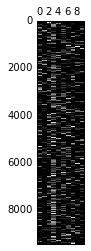

In [100]:
fig = plt.figure(1)
ax = fig.gca()
ax = ax.matshow(doc_topic_distrib, cmap=plt.cm.gray, aspect = '0.005')
plt.show()

In [101]:
topicweights

In [102]:
topicweights = add_topic_weights(dataall,n_topics)

# Save!

In [59]:
import pickleizer

In [93]:
pickleizer.save_topic_analyzer(lda,tf_vectorizer)

In [94]:
pickleizer.save_author(authorid)